### Preliminary Exploratory Data Analysis

In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)

set.seed(1234)

#this library() function loads the tidymodels, repr, tidyverse, and GGally libraries into R
#the set.seed() function sets the seed for the project

In [15]:
data <- read_csv("https://raw.githubusercontent.com/kimtanpalanca/dsci_group_15/main/atp2017-2019.csv")
#the tennnis player data is referred to as the object "data" throughout this analysis

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [16]:
data <- data%>%
    select(winner_name,
           w_ace,
           w_df, 
           w_svpt, 
           w_SvGms, 
           w_1stIn, 
           w_1stWon, 
           loser_name)%>%
#the columns relevant to our analysis are selected using this select() function
    filter(!is.na(winner_name),
           !is.na(w_ace),
           !is.na(w_df),
           !is.na(w_svpt),
           !is.na(w_SvGms),
           !is.na(w_1stIn),
           !is.na(w_1stWon))
#the !is.na() argument in the filter() function eliminates NA values in the relevant columns

head(data, 5)

winner_name,w_ace,w_df,w_svpt,w_SvGms,w_1stIn,w_1stWon,loser_name
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Kei Nishikori,3,3,77,13,44,31,Daniil Medvedev
Daniil Medvedev,10,1,52,10,33,28,Jo Wilfried Tsonga
Kei Nishikori,2,2,47,8,33,26,Jeremy Chardy
Jo Wilfried Tsonga,12,2,68,11,43,34,Alex De Minaur
Daniil Medvedev,12,3,105,16,68,48,Milos Raonic


In [17]:
#the following code tidies the data

player_data <- data%>%
    select(winner_name, 
           loser_name)%>%
    filter(!is.na(winner_name), 
           !is.na(loser_name))
#this code creates a dataframe containing all of the players' names in the original data (both winners and losers)
#the frequency of repetition of these names is equivalent to the number of matches that each player partook in
#(e.g. player X appears twice, he took part in 2 matches)

player_data_column <- data.frame(all_players=unlist(player_data, use.names = FALSE))
#this code creates a single column containing all of the players names

winner_names <- player_data%>%
    group_by(winner_name)%>%
    summarize(n_wins = n())%>%
    distinct()
#this code creates a table containing only the winners names as well as the number of wins of each winning player

n_games_all <- player_data_column%>%
    group_by(all_players)%>%
    summarize(n_games = n())%>%
    subset(all_players %in% winner_names$winner_name)
#this code adds a column to player_data_column containing the number of games each player partook in
#it then extracts the rows which contain player names present in winner_names (i.e. restricts the data to only winners)

winner_data <- tibble(winner_name = winner_names$winner_name,
                      n_wins = winner_names$n_wins, 
                      n_games = n_games_all$n_games)%>%
    mutate(percentage_win = (n_wins/n_games)*100)
#this code creates a tibble containing the winners' names, their number of matches won, and the total number of matches they partook in
#the mutate() function then adds a column detailing the win ratios of each winner in relation to their total number of matches played in (win/total)

data <- data%>%
    group_by(winner_name)%>%
    summarize(number_of_wins = n(),
              avg_ace = mean(w_ace),
              avg_df = mean(w_df),
              avg_svpt = mean(w_svpt),
              avg_svgm = mean(w_SvGms),
              avg_first = mean(w_1stIn),
              avg_first_won = mean(w_1stWon))%>%
#removing repeats in data by averaging all the values over three years
    bind_cols(winner_data)%>%
#combining the relevant columns in winner_data with the data dataframe
    rename(winner_name = winner_name...1)%>%
    mutate(total_avg_svpt = avg_svpt + avg_svgm,
#summing service points and service games (both are points earned by serving)
           first_win_percentage_avg = (avg_first_won/avg_first)*100)%>%
#calculating the percentage of successful first serves
     filter(n_games > 50)%>%
#filtering for winners who play at least 50 games in order to eliminate outliers
    select(percentage_win,
           avg_ace, 
           avg_df, 
           total_avg_svpt, 
           first_win_percentage_avg)%>%
#selecting relevant variables
    mutate(avg_ace = round(avg_ace, 2),
           avg_df = round(avg_df, 2), 
           total_avg_svpt = round(total_avg_svpt, 2), 
           first_win_percentage_avg = round(first_win_percentage_avg, 2),
           percentage_win = round(percentage_win, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

data

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

New names:
* winner_name -> winner_name...1
* winner_name -> winner_name...9



percentage_win,avg_ace,avg_df,total_avg_svpt,first_win_percentage_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51.27,6.02,2.27,92.95,73.35
47.06,3.97,2.32,96.43,71.86
59.26,4.58,2.41,89.00,75.87
69.35,9.06,3.48,88.41,77.35
50.98,9.31,2.17,90.87,78.18
49.56,7.25,2.73,97.30,76.72
55.00,6.70,3.39,91.45,76.13
63.16,7.22,2.89,99.75,74.95
51.90,10.17,5.11,94.68,79.38


### KNN Regression

In [18]:
data_split <- initial_split(data, prop = 0.75, strata = percentage_win)
data_train <- training(data_split)
data_test <- testing(data_split)

#randomly splits 75% of the data into the training and testing sets using
#percentage_win as the strata

In [19]:
recipe <- recipe(percentage_win ~ ., data = data_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

#creating a recipe

In [20]:
folds <- vfold_cv(data_train, v = 10, strata = percentage_win)

#tuning the classifier

In [21]:
model <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

#creating a predictive KNN model

In [22]:
rmspe <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(model) %>%
  tune_grid(resamples = folds, grid = 100) %>%
  collect_metrics() %>%
  filter(.metric == "rmse") %>%
  arrange(mean) %>%
  slice(1) 
rmspe

kmin <- rmspe %>%
    pull(neighbors)
kmin

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,10.69662,10,0.5627384,Model14


[1] 14

In [23]:
model_13 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [24]:
workflow <- workflow() %>%
  add_recipe(recipe) %>%
  add_model(model_13) %>%
  fit(data = data_train)

rmse <- workflow %>%
    predict(data_train) %>%
    bind_cols(data_train) %>%
    metrics(truth = percentage_win, estimate = .pred) %>%
    filter(.metric == "rmse")
rmse

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.19109


In [25]:
summary <- workflow %>%
  predict(data_test) %>%
  bind_cols(data_test) %>%
  metrics(truth = percentage_win, estimate = .pred) %>%
  filter(.metric == "rmse")
summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.584716


In [26]:
predictions <- workflow %>%
  predict(data_train)%>%
  bind_cols(data_train)

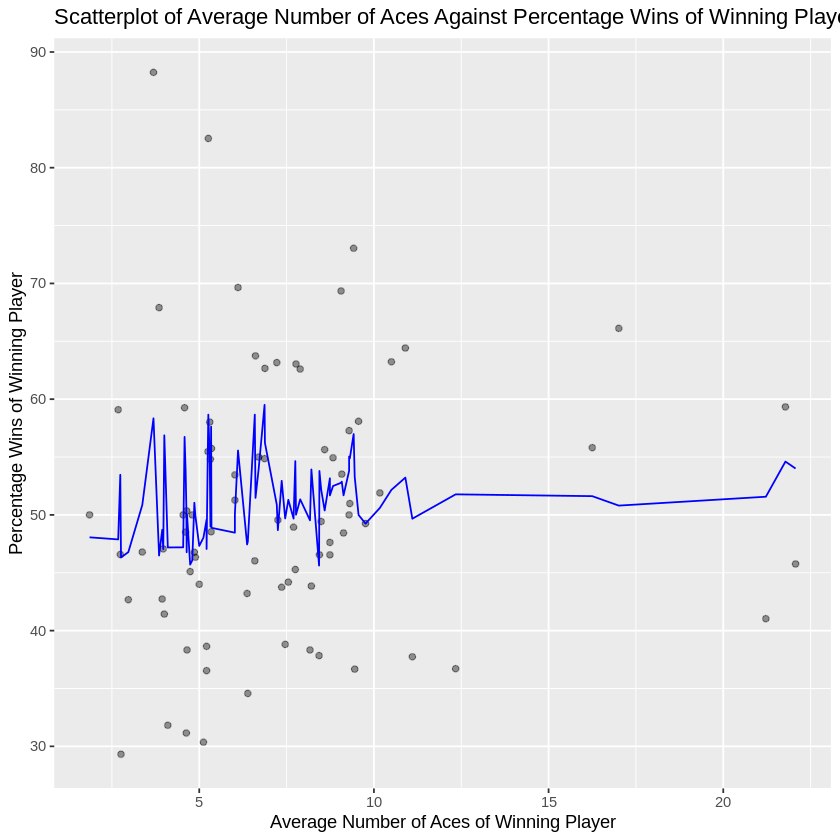

In [27]:
options(repr.plot.width = 7, repr.plot.height = 7)

ace_plot <- ggplot(predictions, aes(x = avg_ace, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Aces of Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = avg_ace, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Aces Against Percentage Wins of Winning Player")

ace_plot

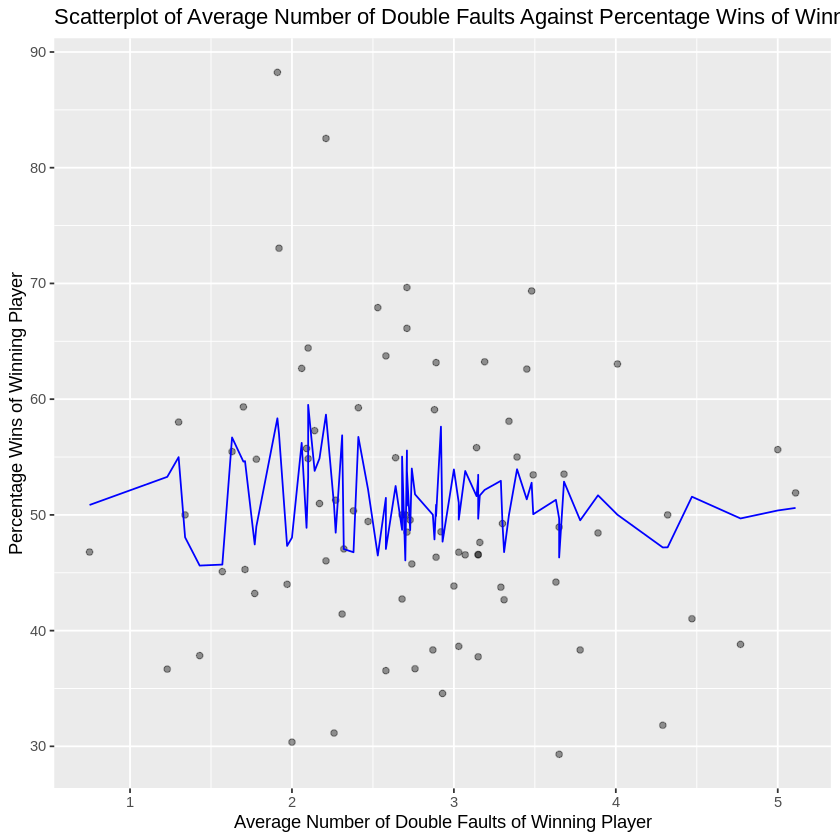

In [29]:
options(repr.plot.width = 7, repr.plot.height = 7)

df_plot <- ggplot(predictions, aes(x = avg_df, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Double Faults of Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = avg_df, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Double Faults Against Percentage Wins of Winning Player")

df_plot

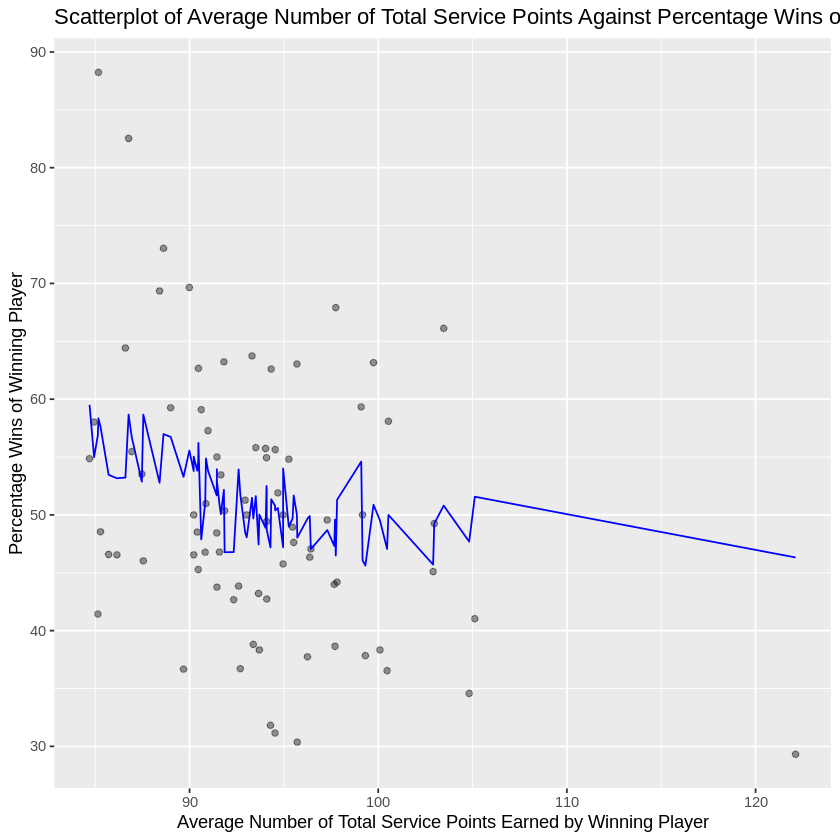

In [31]:
options(repr.plot.width = 7, repr.plot.height = 7)

svpt_plot <- ggplot(predictions, aes(x = total_avg_svpt, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Number of Total Service Points Earned by Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = total_avg_svpt, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Number of Total Service Points Against Percentage Wins of Winning Player")

svpt_plot

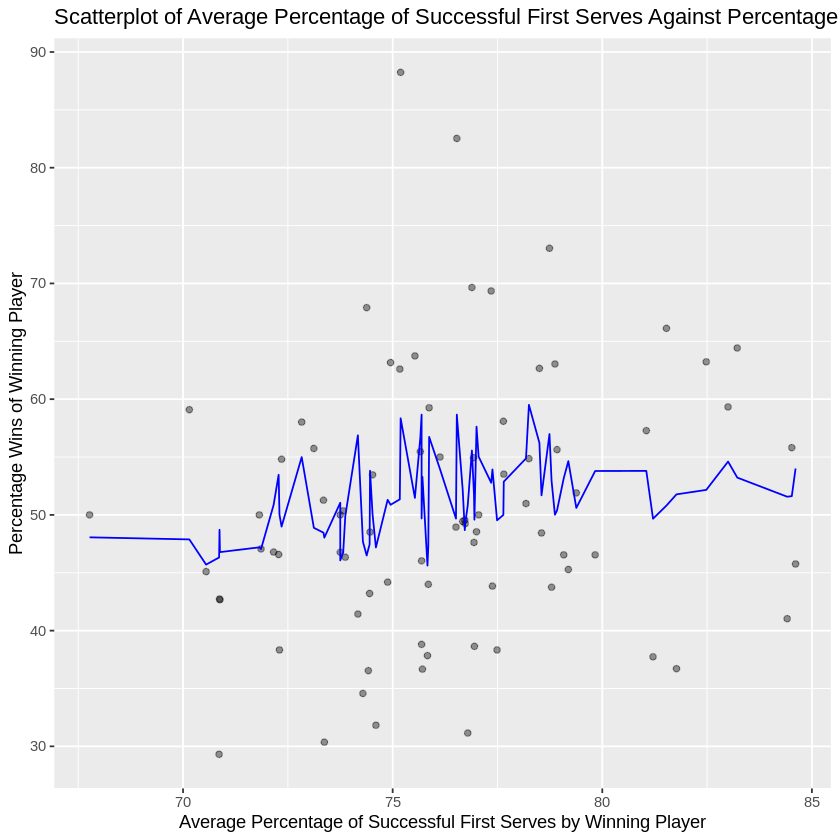

In [32]:
options(repr.plot.width = 7, repr.plot.height = 7)

win_plot <- ggplot(predictions, aes(x = first_win_percentage_avg, y = percentage_win)) +
  geom_point(alpha = 0.4) +
    xlab("Average Percentage of Successful First Serves by Winning Player") +
    ylab("Percentage Wins of Winning Player") +  
    geom_line(data = predictions, 
            mapping = aes(x = first_win_percentage_avg, y = .pred), 
            color = "blue") +
  ggtitle("Scatterplot of Average Percentage of Successful First Serves Against Percentage Wins of Winning Player")

win_plot